# Lab 5

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import torch 
from torch import nn

In [115]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using CUDA (GPU)


## Task 1. Write ResNet architecture by pytorch.

I will try implement this [ResNet](https://arxiv.org/pdf/1512.03385).

### 1. Implement ResNet and bottleneck block

In [116]:
def do_nothing(x):
    """don nothing

    Args:
        x (any)

    Returns:
        any: x
    """
    return x

* ResNet block

In [117]:
class ResBlock(nn.Module):
    """one block of resnet_18 or resnet_34 model

    Args:
        in_out_channels (int): input and output channels
        expansion (int): expansion output channel
    """
    
    
    def __init__(self, in_out_channels, expansion=1):
        super().__init__()
        layers = list()  

        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, in_out_channels*expansion, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels*expansion))
        
        self.layers = nn.Sequential(*layers)
        self.activastion = nn.ReLU()
        
        # if dimension is up
        if in_out_channels != in_out_channels*expansion:
            w = list()
            w.append(nn.Conv2d(in_out_channels, in_out_channels*expansion, kernel_size=3, stride=1, padding=1, bias=False))
            w.append(nn.BatchNorm2d(in_out_channels*expansion))
            self.weights = nn.Sequential(*w)
        else:
            self.weights = do_nothing
    
    
        
    def forward(self, x):
        return self.activastion( self.layers(x) + self.weights(x) )

* BottleNeck block

In [118]:
class BottleNeck(nn.Module):
    """BottleNeck block for resnet_50 model or more layers version

    Args:
        in_out_channels (int): input and output channels
        expansion (int): expansion output channel
    """
    
    def __init__(self, in_out_channels, expansion=4):
        super().__init__()
        layers = list()  
            
        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=1, stride=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, int(in_out_channels*expansion), kernel_size=1, stride=1, bias=False))
        layers.append(nn.BatchNorm2d(int(in_out_channels*expansion)))
        
        self.layers = nn.Sequential(*layers)
        self.activastion = nn.ReLU()
        
        if in_out_channels != in_out_channels*expansion:
            w = list()
            w.append(nn.Conv2d(in_out_channels, int(in_out_channels*expansion), kernel_size=3, stride=1, padding=1, bias=False))
            w.append(nn.BatchNorm2d(int(in_out_channels*expansion)))
            self.weights = nn.Sequential(*w)
        else:
            self.weights = do_nothing
        
    def forward(self, x):
        return self.activastion( self.layers(x) + self.weights(x) )

### 2. Implement resnet layers

In [119]:
class convi_x(nn.Module):
    def __init__(self, in_out_channels, blocks, is_last=False, is_resblock=True):
        """_summary_
        conv2_x, conv3_x, conv4_x, conv5_x layers in one class
        Args:
            in_out_channels (int):  input and output channels
            blocks (int): num of blocks
            is_last (bool, optional): var for checking is it conv5_x. Defaults to False.
            is_resnet (bool, optional): set ups what type of connection will use: Residual or Bottleneck. Defaults to True.        
        """
        super().__init__()
        layers = list()  
               
        if is_last:
            if is_resblock:
                for i in range(blocks):           
                    layers.append(ResBlock(in_out_channels) )
            else:
                layers.append(BottleNeck(in_out_channels))
                for i in range(blocks):           
                    layers.append(BottleNeck(in_out_channels * 4, expansion = 1))
                   
        else:
            if is_resblock:
                for i in range(blocks-1):           
                    layers.append(ResBlock(in_out_channels))                        # channels n->n example input: 64; output: 64
                layers.append(ResBlock( in_out_channels, expansion = 2 ))           # channels n->2*n example input: 64; output: 64
            else:
                layers.append(BottleNeck(in_out_channels))                          # channels n->4*n example input: 64; output: 256
                for i in range(blocks-2):           
                    layers.append(BottleNeck( in_out_channels * 4, expansion = 1))  # channels 4*n->4*n example input: 256; output: 256
                layers.append(BottleNeck( in_out_channels * 4, expansion = 0.5 ))   # channels 4*n->2*n  example input: 256; output: 128
        
            
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

### 3. Implement resnet model

In [120]:
class ResNet(nn.Module):
    def __init__(self, output_channels, architecture = 18, num_blocks = None):
        """ResNet class

        Args:
            output_channels (int): num classes
            architecture (int, optional): articture that will use. Defaults to 18. 
            
            if architecure not defaults like 18, 34, 50 and etc and < 50 will use resnet block, else bottleneck
            num_blocks (list of int, optional): num of blocks for layers. Defaults to None.
        """
        super().__init__()
        
        is_resblock = architecture < 50 # to use resblock or bottleneck block
        
        if num_blocks == None:
            num_blocks = self.get_default_num_blocks(architecture)
                
        blocks = list()
        for i in range(3):
            blocks.append( (64*2**i, num_blocks[i-1], 0) ) # in_out_channels, num of blocks and bool var for conv5_x
        blocks.append((512, num_blocks[-1], 1))

        # Convolutions
        layers = list()
        
        layers.append(nn.Conv2d(3, 64, kernel_size=7, stride=2)) # conv1
        
        layers.append(nn.MaxPool2d(3, 2))
        
        for block in blocks:
            layers.append(convi_x(block[0], block[1], block[2], is_resblock))
            
        
        layers.append(nn.AdaptiveAvgPool2d(1))    
        
        self.layers = nn.Sequential(*layers)
        
        # FC layers + Softmax activation
        self.fcl = nn.Linear(512 if is_resblock else 2048, output_channels)
    
    def get_default_num_blocks(self, architecture) -> list:
        """get default list of numbers of block for defualt architecture

        Args:
            architecture (int): ResNet architecture

        Returns:
            list (int): numbers of block
        """
        num_blocks = list()
        
        if architecture == 152:
            num_blocks = [3, 8, 36, 3]
        elif architecture == 34:
            num_blocks = [3, 4, 6, 3]
        elif architecture == 50:
            num_blocks = [3, 4, 6, 3]
        elif architecture == 101:
            num_blocks = [3, 4, 23, 3]
        else:
            num_blocks = [2, 2, 2, 2]
        
        return num_blocks
    
    def forward(self, x):
        conv_out = self.layers(x)
        conv_out = torch.flatten(conv_out, start_dim=1)
        return self.fcl(conv_out)

Let's check is it work!

In [121]:
ResNet_18 = ResNet(10)
ResNet_50 = ResNet(10, architecture=50).to(device)
x = torch.randn(256, 3, 64, 64)

In [122]:
ResNet_18.forward(x).shape

torch.Size([256, 10])

In [123]:
ResNet_50.forward(x.to(device)).shape

torch.Size([256, 10])

## Train models

### Dataset

Let's train our model and compare with standart pytorch resnets! Will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset

In [124]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

I`ve tried before optimaze models for basic dataset, but models at epoch's 20 starded overfitting, because dataset not big enough, so i'll transform some data

In [125]:
CLASSES = 10

transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dt_train = CIFAR10("datasets/", train=True, transform=transform)
dt_test = CIFAR10("datasets/", train=False, transform=transform)

### Trainloader

In [126]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(dt_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=BATCH_SIZE, shuffle=False)

### Trainloop

took functions from last labs

In [127]:
def train(model, train_loader, optimizer, loss_function):
    """_summary_

    Args:
        model (class): Pytorch nn Module
        train_loader (class): train dataset, pytorch loader
        optimizer (class): optimizer for model
        loss_function (class): loss function for optimization
        is_torch (bool): var for checking torch model

    Returns:
        float: current loss
    """
    model.train()
    current_loss = 0.0      
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        current_loss += loss.item()
            
    return current_loss/len(train_loader)

Added accuracy

In [128]:
def accuracy_score(class_probs, targets, n_classes):
    predictions = class_probs.argmax(dim=1)
    class_idx = np.arange(n_classes)
    
    accuracy = [0 for c in class_idx]
    for c in class_idx:
        accuracy[c] = ((predictions == targets) * (targets == c)).float().sum() / max((targets == c).sum(), 1)
    
    return torch.Tensor(accuracy).to(device)

In [129]:
def validate(model, valid_loader, loss_function):
    model.eval()
    loss = 0.0
    accuracy = 0.0
    current_loss = 0.0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
                        
            output = model(inputs)
            
            loss = loss_function(output, targets)
            
            current_loss += loss
            accuracy += accuracy_score(output, targets, 10)
            
    current_loss /= len(valid_loader)
    accuracy /= len(valid_loader)
    
    print(accuracy)
    
    return current_loss, accuracy

In [130]:
def trainloop(model, train_loader, valid_loader, lr = 0.1, epochs = 50,  name="model"):
    """_summary_

    Args:
        model (class): Pytorch nn Module
        train_loader (class): train dataset, pytorch loader
        valid_loader (class): validation dataset, pytorch loader
        lr (float) : learning rate
        name (str): name of file 

    Returns:
        best_model: best model of train
        train_loss_list: list of train loss models
        valid_loss_list: list of valid loss models
        accuracy_loss_list: list of accuracy models
        
    """
    learning_rate = lr
    n_epochs = epochs
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    loss_function = nn.CrossEntropyLoss().to(device)

    train_loss_list = list()
    valid_loss_list = list()
    accuracy = list()

    best_accuracy = 0
    best_valid = torch.inf
    best_model = None

    for epoch in range(n_epochs):
            
        train_loss = train(model, train_loader, optimizer, loss_function)
        train_loss_list.append(train_loss)
        
        valid_loss, current_accuracy = validate(model, valid_loader, loss_function)
        valid_loss_list.append(valid_loss)
        
        mean_accuracy = torch.mean(current_accuracy)
        
        if best_accuracy < mean_accuracy and valid_loss < best_valid:
            best_valid = valid_loss
            accuracy = current_accuracy
            best_accuracy = mean_accuracy
            best_model = model
            torch.save(model, 'models/lab5-best-'+ name +'.pt')
            torch.save(model.state_dict(), 'models/lab5-best-'+ name  +'-parameters.pt')       
        
        print(f"Epoch {epoch+1}: train_loss = {train_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: valid_loss = {valid_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: accuracy = {mean_accuracy}")
            
    return best_model, train_loss_list, valid_loss_list, accuracy

In [131]:
resnet18 = ResNet(CLASSES, architecture=18).to(device)
resnet34 = ResNet(CLASSES, architecture=34).to(device)
resnet50 = ResNet(CLASSES, architecture=50).to(device)

resnet18_toch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
resnet34_toch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34')

Using cache found in C:\Users\VELIKIY/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\VELIKIY/.cache\torch\hub\pytorch_vision_v0.10.0


In [132]:
resnet18_toch.fc = nn.Linear(resnet18_toch.fc.in_features, CLASSES)
resnet34_toch.fc = nn.Linear(resnet34_toch.fc.in_features, CLASSES)

resnet18_toch.to(device)
resnet34_toch.to(device)

print()

In [133]:
my_best_resnet_18, tll_my_18, vll_my18, ac_my18 = trainloop(resnet18, train_loader, test_loader, name="my_resnet18")

tensor([0.2763, 0.5590, 0.0173, 0.0000, 0.4167, 0.5192, 0.1175, 0.2962, 0.5944,
        0.2783], device='cuda:0')
Epoch 1: train_loss = 2.2419467786388934
Epoch 1: valid_loss = 1.840761661529541
Epoch 1: accuracy = 0.3074897825717926
tensor([0.4353, 0.4496, 0.1932, 0.1834, 0.2200, 0.5664, 0.4256, 0.5928, 0.3706,
        0.5112], device='cuda:0')
Epoch 2: train_loss = 1.6995509213498792
Epoch 2: valid_loss = 1.61271333694458
Epoch 2: accuracy = 0.39481085538864136
tensor([0.6201, 0.2542, 0.1930, 0.0431, 0.4200, 0.6573, 0.5619, 0.6944, 0.3529,
        0.4569], device='cuda:0')
Epoch 3: train_loss = 1.534947105076002
Epoch 3: valid_loss = 1.5535390377044678
Epoch 3: accuracy = 0.42537856101989746
tensor([0.4838, 0.5135, 0.2103, 0.1317, 0.3135, 0.7053, 0.3047, 0.6422, 0.7178,
        0.7401], device='cuda:0')
Epoch 4: train_loss = 1.3706594300087152
Epoch 4: valid_loss = 1.4398530721664429
Epoch 4: accuracy = 0.47629329562187195
tensor([0.6075, 0.6514, 0.2270, 0.5140, 0.5910, 0.5988, 0.426

In [135]:
torch_best_resnet_18, tll_torch_18, vll_torch_18, ac_torch18 = trainloop(resnet18_toch, train_loader, test_loader, name="torch_resnet18")

tensor([0.4111, 0.4605, 0.1589, 0.0461, 0.3317, 0.6729, 0.4740, 0.4126, 0.6261,
        0.4347], device='cuda:0')
Epoch 1: train_loss = 2.1454663423016247
Epoch 1: valid_loss = 1.618739128112793
Epoch 1: accuracy = 0.40285101532936096
tensor([0.4848, 0.5155, 0.1761, 0.1522, 0.3221, 0.5539, 0.5960, 0.6462, 0.6971,
        0.6187], device='cuda:0')
Epoch 2: train_loss = 1.5178787485717813
Epoch 2: valid_loss = 1.3983683586120605
Epoch 2: accuracy = 0.47625622153282166
tensor([0.4725, 0.7304, 0.2730, 0.1430, 0.4959, 0.5630, 0.6356, 0.6306, 0.8167,
        0.4384], device='cuda:0')
Epoch 3: train_loss = 1.3606438283115396
Epoch 3: valid_loss = 1.277730941772461
Epoch 3: accuracy = 0.5199129581451416
tensor([0.8020, 0.8301, 0.3265, 0.5042, 0.5900, 0.4291, 0.6364, 0.6033, 0.6383,
        0.4267], device='cuda:0')
Epoch 4: train_loss = 1.2122086099041698
Epoch 4: valid_loss = 1.1737598180770874
Epoch 4: accuracy = 0.578644871711731
tensor([0.5579, 0.5007, 0.5583, 0.4075, 0.5788, 0.5596, 0.426

In [137]:
torch_best_resnet_34, tll_torch_34, vll_torch_34, ac_torch34 = trainloop(resnet34_toch, train_loader, test_loader, name="torch_resnet34")

tensor([0.1286, 0.2833, 0.1501, 0.0222, 0.2013, 0.2571, 0.5409, 0.2837, 0.5385,
        0.5056], device='cuda:0')
Epoch 1: train_loss = 2.4541550298481036
Epoch 1: valid_loss = 1.9606291055679321
Epoch 1: accuracy = 0.2911355793476105
tensor([0.2474, 0.2965, 0.0646, 0.1719, 0.1332, 0.5173, 0.4932, 0.5383, 0.4725,
        0.3934], device='cuda:0')
Epoch 2: train_loss = 1.8099199868833926
Epoch 2: valid_loss = 1.8200135231018066
Epoch 2: accuracy = 0.33283063769340515
tensor([0.4784, 0.4973, 0.0422, 0.1430, 0.3928, 0.5222, 0.4303, 0.6365, 0.3431,
        0.5195], device='cuda:0')
Epoch 3: train_loss = 1.6853265966600774
Epoch 3: valid_loss = 1.6032334566116333
Epoch 3: accuracy = 0.40053272247314453
tensor([0.2711, 0.5109, 0.0420, 0.2666, 0.3354, 0.4802, 0.6259, 0.6148, 0.5623,
        0.6107], device='cuda:0')
Epoch 4: train_loss = 1.5829102566175144
Epoch 4: valid_loss = 1.514339566230774
Epoch 4: accuracy = 0.43198075890541077
tensor([0.4313, 0.6303, 0.4396, 0.4434, 0.2467, 0.4064, 0.

Text(0, 0.5, 'Cross-entropy validation loss')

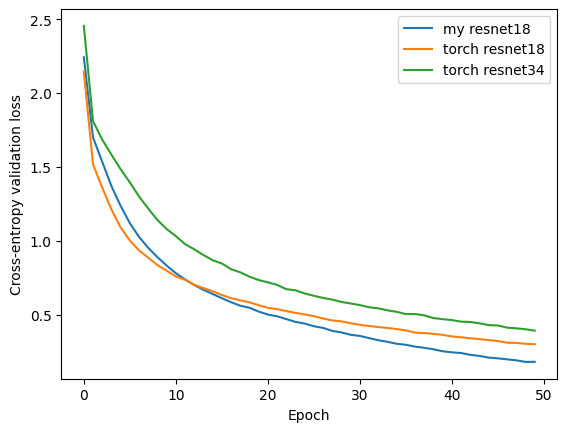

In [138]:
sns.lineplot(tll_my_18, label="my resnet18")
sns.lineplot(tll_torch_18, label="torch resnet18")
sns.lineplot(tll_torch_34, label="torch resnet34")

plt.xlabel("Epoch")
plt.ylabel("Cross-entropy validation loss")

In [158]:
def list_tensor_to_list_floats(lt):
    lf = []
    for i in lt:
        lf.append(float(i.cpu().detach().numpy()))
    return lf

In [ ]:
vll_my18 = list_tensor_to_list_floats(vll_my18)
vll_torch_18 = list_tensor_to_list_floats(vll_torch_18)
vll_torch_34 = list_tensor_to_list_floats(vll_torch_34)

Text(0, 0.5, 'Cross-entropy validation loss')

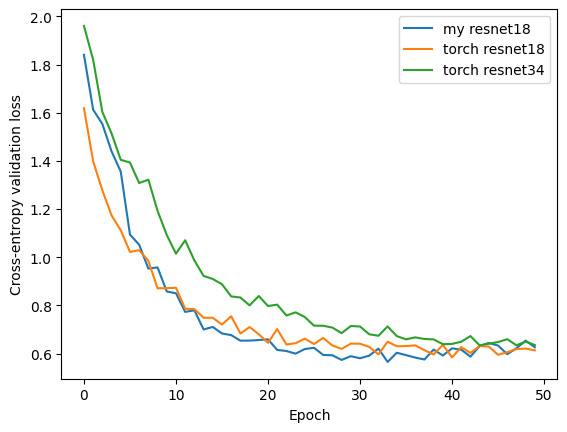

In [169]:
sns.lineplot(vll_my18, label="my resnet18")
sns.lineplot(vll_torch_18, label="torch resnet18")
sns.lineplot(vll_torch_34, label="torch resnet34")

plt.xlabel("Epoch")
plt.ylabel("Cross-entropy validation loss")

We can see that models could more epoch train and not overfitted, but for just example this enough :)

In [170]:
ac_my18

tensor([0.8194, 0.9043, 0.7417, 0.6467, 0.7963, 0.7775, 0.8512, 0.8597, 0.8873,
        0.8223], device='cuda:0')

In [171]:
ac_torch18

tensor([0.8431, 0.9162, 0.6759, 0.6739, 0.7959, 0.7043, 0.8564, 0.8778, 0.8907,
        0.8308], device='cuda:0')

In [172]:
ac_torch34

tensor([0.8405, 0.8994, 0.7097, 0.6253, 0.7246, 0.6740, 0.8643, 0.8487, 0.8781,
        0.8445], device='cuda:0')

In [191]:
ac_df_my18 = pd.DataFrame()
ac_df_my18["class"] = [i for i in range(1, 11)]
ac_df_my18["accuracy"] = ac_my18.cpu().detach().numpy()
ac_df_my18['model'] = 'my_resnet18'

ac_df_torch18 = pd.DataFrame()
ac_df_torch18["class"] = [i for i in range(1, 11)]
ac_df_torch18["accuracy"] = ac_torch18.cpu().detach().numpy()
ac_df_torch18['model'] = 'torch_resnet18'

ac_df_torch34 = pd.DataFrame()
ac_df_torch34["class"] = [i for i in range(1, 11)]
ac_df_torch34["accuracy"] = ac_torch34.cpu().detach().numpy()
ac_df_torch34['model'] = 'torch_resnet34'

models_accuracy = pd.concat([ac_df_my18, ac_df_torch18, ac_df_torch34])

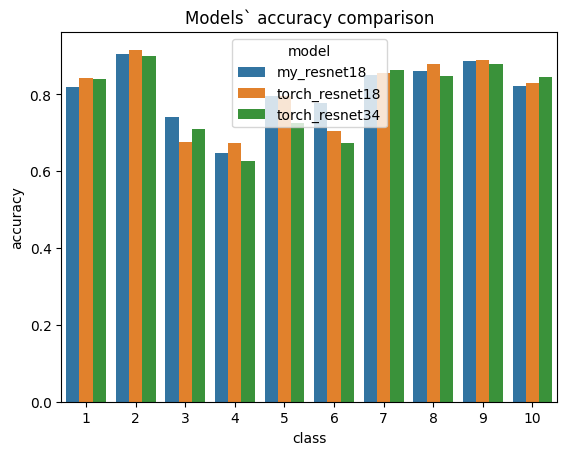

In [192]:
sns.barplot(data=models_accuracy,
            x='class', y='accuracy', hue='model')
plt.title('Models` accuracy comparison')
plt.show()

We can see that models have same accuracy

## Conclusions

* wrote own resblocks, reslayers, resnet
* used cifar-10 to compare my model with pytorch models
* added in dataset more photos by using transform's matrix to avoid overfitting
* got almoust the same results